# Miniproyecto 2

En este Jupyter Notebook pueden implementar los códigos necesarios para resolver el **Miniproyecto 2**.

**Importante:** Recuerden que, como grupo, deben **adjuntar el código** en su entrega. En caso de que desarrollen parte del trabajo en este notebook pero **no lo incluyan en la entrega**, **toda la sección de calificación correspondiente al código será evaluada con cero**.

Tengan en cuenta que Coursera utiliza recursos compartidos entre todos los grupos, por lo tanto, si hay muchos equipos trabajando al mismo tiempo, los procesos pueden demorar más de lo previsto.

Pueden agregar todas las celdas de código que consideren necesarias para resolver el miniproyecto. **No hay un límite en este aspecto.**

In [1]:
# Espacio para desarrollar el código del miniproyecto 2

In [2]:
! pip install kagglehub
! pip install kagglehub[pandas-datasets]


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


In [3]:
import numpy as np
import random
import os
import tensorflow as tf
def set_seed(seed=42):
    np.random.seed(seed)
    random.seed(seed)
    tf.random.set_seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)

set_seed(42)

In [4]:
import kagglehub
import os
import glob
import pandas as pd

path = kagglehub.dataset_download("yasserh/imdb-movie-ratings-sentiment-analysis")

for root, dirs, files in os.walk(path):
    for name in files:
        print(" -", os.path.join(root, name))

csv_files = glob.glob(f"{path}/**/*.csv", recursive=True)

if not csv_files:
    raise FileNotFoundError("No se encontró ningún archivo .csv en el dataset descargado.")

csv_path = csv_files[0]

data_raw = pd.read_csv(csv_path)

print("\nPrimeras 5 filas del dataset:")
print(data_raw.head())


 - /root/.cache/kagglehub/datasets/yasserh/imdb-movie-ratings-sentiment-analysis/versions/1/movie.csv

Primeras 5 filas del dataset:
                                                text  label
0  I grew up (b. 1965) watching and loving the Th...      0
1  When I put this movie in my DVD player, and sa...      0
2  Why do people who do not know what a particula...      0
3  Even though I have great interest in Biblical ...      0
4  Im a die hard Dads Army fan and nothing will e...      1


In [5]:
data = data_raw.copy()
data.shape

(40000, 2)

In [6]:
data.value_counts('label')

label
0    20019
1    19981
dtype: int64

## Preprocesado

### Tokenizer

In [7]:
! pip install nltk
import nltk
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.tokenize import word_tokenize


[notice] A new release of pip is available: 23.3.2 -> 25.0.1
[notice] To update, run: python -m pip install --upgrade pip


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [8]:
text = data['text'][0]
tokens = word_tokenize(text)
print(tokens)

['I', 'grew', 'up', '(', 'b', '.', '1965', ')', 'watching', 'and', 'loving', 'the', 'Thunderbirds', '.', 'All', 'my', 'mates', 'at', 'school', 'watched', '.', 'We', 'played', '``', 'Thunderbirds', "''", 'before', 'school', ',', 'during', 'lunch', 'and', 'after', 'school', '.', 'We', 'all', 'wanted', 'to', 'be', 'Virgil', 'or', 'Scott', '.', 'No', 'one', 'wanted', 'to', 'be', 'Alan', '.', 'Counting', 'down', 'from', '5', 'became', 'an', 'art', 'form', '.', 'I', 'took', 'my', 'children', 'to', 'see', 'the', 'movie', 'hoping', 'they', 'would', 'get', 'a', 'glimpse', 'of', 'what', 'I', 'loved', 'as', 'a', 'child', '.', 'How', 'bitterly', 'disappointing', '.', 'The', 'only', 'high', 'point', 'was', 'the', 'snappy', 'theme', 'tune', '.', 'Not', 'that', 'it', 'could', 'compare', 'with', 'the', 'original', 'score', 'of', 'the', 'Thunderbirds', '.', 'Thankfully', 'early', 'Saturday', 'mornings', 'one', 'television', 'channel', 'still', 'plays', 'reruns', 'of', 'the', 'series', 'Gerry', 'Anderso

### Stemming: SnowBallStemmer

In [9]:
from nltk.stem import SnowballStemmer
stemmer = SnowballStemmer("english") 
stemmer.stem(text)

'i grew up (b. 1965) watching and loving the thunderbirds. all my mates at school watched. we played "thunderbirds" before school, during lunch and after school. we all wanted to be virgil or scott. no one wanted to be alan. counting down from 5 became an art form. i took my children to see the movie hoping they would get a glimpse of what i loved as a child. how bitterly disappointing. the only high point was the snappy theme tune. not that it could compare with the original score of the thunderbirds. thankfully early saturday mornings one television channel still plays reruns of the series gerry anderson and his wife created. jonatha frakes should hand in his directors chair, his version was completely hopeless. a waste of film. utter rubbish. a cgi remake may be acceptable but replacing marionettes with homo sapiens subsp. sapiens was a huge error of judgment.'

### Embeddings: Tf-IDF Vectorizer

In [10]:
from sklearn.feature_extraction.text import TfidfVectorizer

### Pipeline completo de preprocesamiento

In [11]:
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer


In [12]:
import re
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

lemmatizer = WordNetLemmatizer() 
stop_words = set(stopwords.words('english'))

def preprocess_text_lemmatized(text):
    # 1. Limpieza con Regex
    text = re.sub(r'<[^>]+>', '', text)      # HTML tags
    text = re.sub(r'http\S+|www\S+', '', text) # URLs
    text = re.sub(r'\S+@\S+', '', text)      # Emails
    #text = re.sub(r'\d+', '', text)          # Números
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Puntuación y caracteres especiales
    text = text.lower()
    
    tokens = word_tokenize(text)
    
    lemmas = [lemmatizer.lemmatize(token) 
              for token in tokens 
              if token not in stop_words and len(token) > 2]
    
    # 4. Unión
    return ' '.join(lemmas)

# Lambda sobre la columna (usa la nueva función)
preprocessor = FunctionTransformer(lambda X: X.apply(preprocess_text_lemmatized))

# Pipeline (sin cambios en la estructura)
procesador = Pipeline([
    ('preprocessor', preprocessor)])

## Modelo

In [13]:
from sklearn.model_selection import train_test_split

In [14]:
# Split de datos
X = data['text']
y = data['label']
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=27)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)
#### segunda parte

X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=27)
#---

print("Forma de X_train:", X_train.shape)
print("Forma de X_val:", X_val.shape)
print("Forma de X_test:", X_test.shape)

Forma de X_train: (28000,)
Forma de X_val: (6000,)
Forma de X_test: (6000,)


In [15]:
X_train.shape

(28000,)

In [16]:
X_train[0]

'I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played "Thunderbirds" before school, during lunch and after school. We all wanted to be Virgil or Scott. No one wanted to be Alan. Counting down from 5 became an art form. I took my children to see the movie hoping they would get a glimpse of what I loved as a child. How bitterly disappointing. The only high point was the snappy theme tune. Not that it could compare with the original score of the Thunderbirds. Thankfully early Saturday mornings one television channel still plays reruns of the series Gerry Anderson and his wife created. Jonatha Frakes should hand in his directors chair, his version was completely hopeless. A waste of film. Utter rubbish. A CGI remake may be acceptable but replacing marionettes with Homo sapiens subsp. sapiens was a huge error of judgment.'

In [17]:
y_train.shape

(28000,)

In [18]:
print(f"Primera frase: {X_train[0][0:100]}\n (.....) tiene el label {y_train[0]}")

Primera frase: I grew up (b. 1965) watching and loving the Thunderbirds. All my mates at school watched. We played 
 (.....) tiene el label 0


### Transform

In [19]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
import re

In [29]:
# Aplicar pipeline
X_train_pre = procesador.fit_transform(X_train) 
X_val_pre = procesador.transform(X_val)
X_test_pre = procesador.transform(X_test)

# Parámetros para tokenización y modelo
MAX_VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 500
EMBEDDING_DIM = 256
LSTM_UNITS = 32

# Tokenización en textos preprocesados
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train_pre)  # Fit solo en train preprocesado

# to_sequences
X_train_seq = tokenizer.texts_to_sequences(X_train_pre)
X_val_seq = tokenizer.texts_to_sequences(X_val_pre)
X_test_seq = tokenizer.texts_to_sequences(X_test_pre)

# Padear
X_train_padded = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_val_padded = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')
X_test_padded = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH, padding='post', truncating='post')

# Verifica formas padded
print("Forma de X_train_padded:", X_train_padded.shape)
print("Forma de X_val_padded:", X_val_padded.shape)
print("Forma de X_test_padded:", X_test_padded.shape)

# Convierte y a arrays
y_train = np.array(y_train)
y_val = np.array(y_val)
y_test = np.array(y_test)

Forma de X_train_padded: (28000, 500)
Forma de X_val_padded: (6000, 500)
Forma de X_test_padded: (6000, 500)


In [30]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional,GRU
from tensorflow.keras import regularizers


model = Sequential([
    #Embedding
    Embedding(input_dim=MAX_VOCAB_SIZE,
              output_dim=EMBEDDING_DIM,
              input_length=MAX_SEQUENCE_LENGTH),
    # LSTM bidireccional para capturar contexto anterior y posterior
    Bidirectional(LSTM(LSTM_UNITS, return_sequences=False,
                       kernel_regularizer=regularizers.l2(1e-4), #Regularización L2
                       recurrent_regularizer=regularizers.l2(1e-4))),#Regularización L2                   
    # Regularización por Dropout
    Dropout(0.5),
    # Capa densa intermedia para mayor capacidad de representación
    Dense(128, activation='relu', kernel_regularizer=regularizers.l2(1e-4)),
    # Regularización #2 por Dropout
    Dropout(0.4),
    Dense(1, activation='sigmoid')])

# Compilar
model.compile(optimizer='adamax',
              loss='binary_crossentropy',
              metrics=['accuracy'])

# Resumen
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 500, 256)          2560000   
                                                                 
 bidirectional_2 (Bidirectio  (None, 64)               73984     
 nal)                                                            
                                                                 
 dropout_4 (Dropout)         (None, 64)                0         
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                                 
 dropout_5 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 1)                 129       
                                                      

In [31]:
from tensorflow.keras.callbacks import EarlyStopping

early_stop = EarlyStopping(monitor='val_loss', patience=2, restore_best_weights=True)

history = model.fit(
    X_train_padded, y_train,
    epochs=15,
    batch_size=32,
    validation_data=(X_val_padded, y_val),
    callbacks=[early_stop],
    verbose=1
)


Epoch 1/15
875/875 [==============================] - 32s 35ms/step - loss: 0.4851 - accuracy: 0.7744 - val_loss: 0.3399 - val_accuracy: 0.8707
Epoch 2/15
875/875 [==============================] - 30s 34ms/step - loss: 0.3015 - accuracy: 0.8932 - val_loss: 0.3176 - val_accuracy: 0.8783
Epoch 3/15
875/875 [==============================] - 30s 34ms/step - loss: 0.2532 - accuracy: 0.9141 - val_loss: 0.3227 - val_accuracy: 0.8823
Epoch 4/15
875/875 [==============================] - 30s 34ms/step - loss: 0.2226 - accuracy: 0.9270 - val_loss: 0.3174 - val_accuracy: 0.8828
Epoch 5/15
875/875 [==============================] - 30s 34ms/step - loss: 0.2023 - accuracy: 0.9362 - val_loss: 0.3484 - val_accuracy: 0.8788
Epoch 6/15
875/875 [==============================] - 30s 34ms/step - loss: 0.1828 - accuracy: 0.9424 - val_loss: 0.3530 - val_accuracy: 0.8790


In [32]:
# Evaluar
test_loss, test_acc = model.evaluate(X_test_padded, y_test)
print(f"Test Accuracy: {test_acc:.4f}")

188/188 [==============================] - 3s 16ms/step - loss: 0.3273 - accuracy: 0.8752
Test Accuracy: 0.8752


188/188 [==============================] - 3s 15ms/step


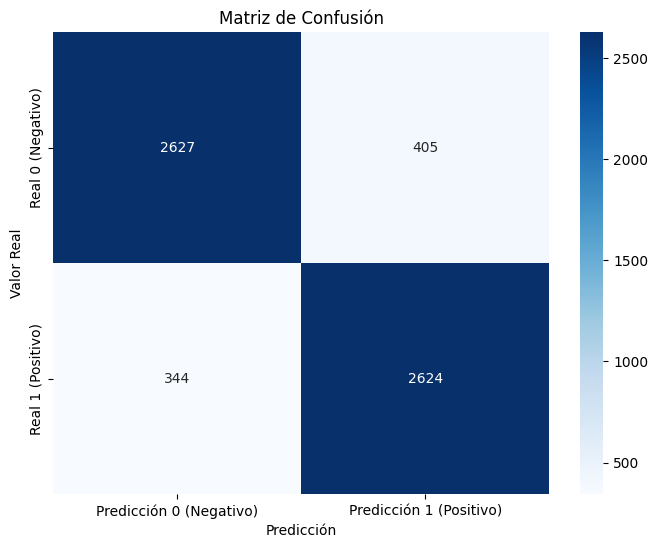

Matriz de Confusión:
[[2627  405]
 [ 344 2624]]

Verdaderos Positivos (TP): 2624
Falsos Positivos (FP): 405
Verdaderos Negativos (TN): 2627
Falsos Negativos (FN): 344


In [33]:
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 1. Obtener predicciones (probabilidades)
y_pred_probs = model.predict(X_test_padded)

# 2. Convertir probabilidades a clases binarias (0 o 1)
# Si la probabilidad es > 0.5, se predice 1 (clase positiva), sino 0 (clase negativa)
y_pred_classes = np.where(y_pred_probs > 0.5, 1, 0)

# 3. Calcular la Matriz de Confusión
cm = confusion_matrix(y_test, y_pred_classes)

# 4. Visualizar la Matriz de Confusión
plt.figure(figsize=(8, 6))
# Se asume que las etiquetas son 0 y 1.
# En el contexto de reseñas de texto, 0 podría ser "Negativa" y 1 "Positiva".
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Predicción 0 (Negativo)', 'Predicción 1 (Positivo)'], 
            yticklabels=['Real 0 (Negativo)', 'Real 1 (Positivo)'])
plt.title('Matriz de Confusión')
plt.xlabel('Predicción')
plt.ylabel('Valor Real')
plt.show()

# 5. Imprimir la matriz de forma legible (opcional)
print("Matriz de Confusión:")
print(cm)

# 6. Cálculo de métricas secundarias (opcional, pero útil)
tn, fp, fn, tp = cm.ravel()
print(f"\nVerdaderos Positivos (TP): {tp}")
print(f"Falsos Positivos (FP): {fp}")
print(f"Verdaderos Negativos (TN): {tn}")
print(f"Falsos Negativos (FN): {fn}")

In [34]:
def visualization_history(resultsFit):
    """
    Esta función grafica las curvas de pérdida a lo largo de las épocas de entrenamiento
    para el conjunto de prueba como el de validación.
    Parámetros:
    resultsFit = historial de entrenamiento de un modelo en keras
    Salida:
    Gráfica de la precisión en validación y prueba.
    """
    # Llamado al entrono de la gráfica y fijar tamaño de visualización
    fig, axes = plt.subplots(1, 1, figsize=(13, 4))

    # Graficar la pérdida de la historia en entrenamiento
    axes.plot(range(len(resultsFit.history['loss'])), resultsFit.history['loss'],
           '#5a2ff4', linestyle = "-", marker = ".",
           label='Pérdida entrenamiento', lw = 2)

    # Graficar la presición de la historia en validación
    axes.plot(range(len(resultsFit.history['val_loss'])), resultsFit.history['val_loss'],  '#60d13e',
           label='Pérdida validación', linestyle = '-', marker = '.', lw =2)

    # Títulos de los ejes
    axes.set_xlabel('Época',fontsize=12)
    axes.set_ylabel(r'Pérdida',fontsize=12)
    axes.grid()      # Activar la cuadricula
    axes.legend(fontsize=12,loc = 'upper right')   # Establecer la legenda


    plt.tight_layout() # Ajusta automáticamente el diseño de la figura
    plt.show()

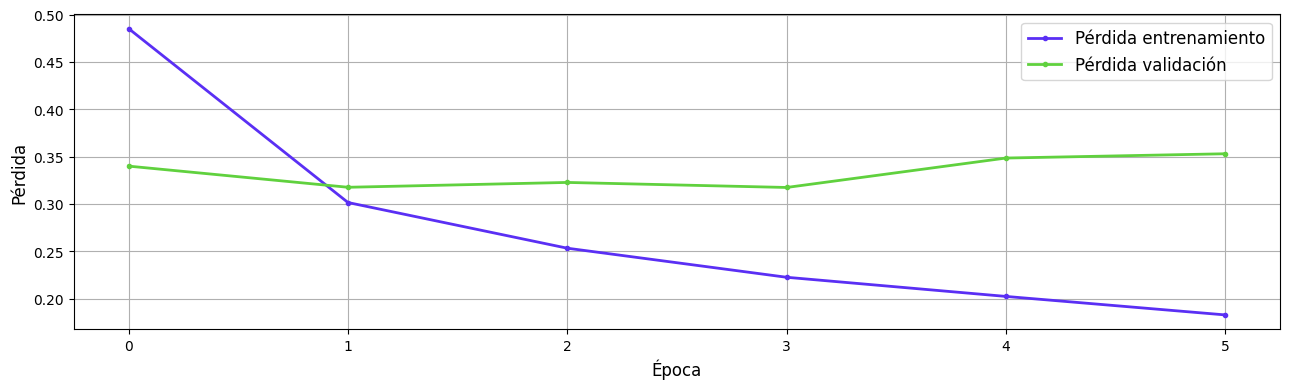

In [35]:
# Llamado a la función de visualización de las métricas de la historia del entrenamiento
# del modelo.
import matplotlib.pyplot as plt
visualization_history(history)

# Pytorch approach